In [1]:
import os
import mmcv
import itertools
import infer
import cv2
import matplotlib.pyplot as plt
import line_utils
import numpy as np
import pandas as pd
import json
from mmdet.apis import (inference_detector, init_detector)
from skimage.morphology import skeletonize
from scipy.interpolate import CubicSpline, interp1d
import sys
from clean_chart import get_clean_input
import copy
from tqdm import tqdm

/home/ipsavi/anaconda3/envs/LineFormer/lib/python3.8/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
import os
import sys
import json
import math
import itertools
# import editdistance
import numpy as np
import scipy.optimize
import scipy.spatial.distance

def check_groups(ds):
    try:
        _i = ds[0][0]
        return 1
    except Exception:
        return 0

def pprint(obj):
    print(json.dumps(obj, indent=4, sort_keys=True))

def get_dataseries(json_obj):
    if 'task6_output' in json_obj:
        return json_obj['task6_output']['visual elements']
    elif 'task6' in json_obj:
        return json_obj['task6']['output']['visual elements']
    return None

def euclid(p1, p2):
    x1 = float(p1['x'])
    y1 = float(p1['y'])
    x2 = float(p2['x'])
    y2 = float(p2['y'])
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

# def box_to_discrete(ds):
#     out = []
#     for it_name in ['first_quartile', 'max', 'min', 'median', 'third_quartile']: 
#         out.append( {'name': it_name, 'x': ds[it_name]['x'], 'y': ds[it_name]['y']} )
#     return out

def box_arr_to_np(ds):
    n = np.zeros( (1, 8))
    cnt_q = 0
    for _i,p in enumerate(ds):
        n[0,cnt_q] = float(ds[p]['y'])
        n[0,cnt_q+1] = float(ds[p]['x'])
        cnt_q = cnt_q+1
    return n

def compare_box(pred_ds, gt_ds, min_dim):
    pred_ds = box_arr_to_np(pred_ds)
    gt_ds = box_arr_to_np(gt_ds)
    cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_ds, gt_ds, metric='cityblock') /(min_dim*0.05))
    return cost_mat

def scatt_arr_to_np(ds):
    n = np.zeros((len(ds), 2))
    for i, p in enumerate(ds):
        n[i,0] = float(p['x'])
        n[i,1] = float(p['y'])
    return n

def bar_arr_to_np(ds):
    n = np.zeros([1,4])
    n[0,0] = float(ds['y0'])
    n[0,1] = float(ds['x0'])
    n[0,2] = float(ds['height']) + float(ds['y0'])
    n[0,3] = float(ds['width']) + float(ds['x0'])
    return n

def compare_bar(pred_ds, gt_ds, min_dim):
    pred_ds = bar_arr_to_np(pred_ds)
    gt_ds = bar_arr_to_np(gt_ds)

    cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_ds, gt_ds, metric='cityblock') /(min_dim*0.05))
    return cost_mat

def compare_scatter(pred_ds, gt_ds, min_dim, gamma, beta):

    is_grouped = check_groups(gt_ds)

    if is_grouped:
        len_seq = len(gt_ds)
    else:
        len_seq = 1
        pred_ds = [pred_ds]
        gt_ds = [gt_ds]

    score = np.zeros((len(gt_ds), len(pred_ds)))
    for iter_seq1 in range(len(gt_ds)):
        gt_seq = scatt_arr_to_np(gt_ds[iter_seq1])

        for iter_seq2 in range(len(pred_ds)):
            pred_seq = scatt_arr_to_np(pred_ds[iter_seq2])

            # V = np.cov(gt_ds.T)
            # VI = np.linalg.inv(V).T

            #cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_ds, gt_ds, metric='mahalanobis', VI=VI) / gamma)
            cost_mat = np.minimum(1, scipy.spatial.distance.cdist(pred_seq, gt_seq, metric='euclidean') / (min_dim*gamma))

            score[iter_seq1, iter_seq2] = get_score(cost_mat)

    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-score)
    score = score[row_ind, col_ind].sum()/(float(len(gt_ds))*beta)

    return score

def get_score(cost_mat):
    cost_mat = pad_mat(cost_mat)
    k = cost_mat.shape[0]
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(cost_mat)

    cost = cost_mat[row_ind, col_ind].sum()
    score = 1 - (cost / k)
    return score

def get_cont_recall(p_xs, p_ys, g_xs, g_ys, epsilon):
    total_score = 0
    total_interval = 0

    for i in range(g_xs.shape[0]):
        x = g_xs[i]

        if g_xs.shape[0] == 1:
            interval = 1
        elif i == 0:
            interval = (g_xs[i+1] - x) / 2
        elif i == (g_xs.shape[0] - 1):
            interval = (x - g_xs[i-1]) / 2
        else:
            interval = (g_xs[i+1] - g_xs[i-1]) / 2

        y = g_ys[i]
        y_interp = np.interp(x, p_xs, p_ys)
        error = min(1, abs( (y - y_interp) / (abs(y) + epsilon)))
        total_score += (1 - error) * interval
        total_interval += interval

    if g_xs.shape[0] != 1:
        assert np.isclose(total_interval, g_xs[-1] - g_xs[0])
    return total_score / total_interval

def compare_continuous(pred_ds, gt_ds):
    pred_ds = sorted(pred_ds, key=lambda p: float(p['x']))
    gt_ds = sorted(gt_ds, key=lambda p: float(p['x']))

    if not pred_ds and not gt_ds:
        # empty matches empty
        return 1.0
    elif not pred_ds and gt_ds:
        # empty does not match non-empty
        return 0.0
    elif pred_ds and not gt_ds:
        # empty does not match non-empty
        return 0.0

    p_xs = np.array([float(ds['x']) for ds in pred_ds])
    p_ys = np.array([float(ds['y']) for ds in pred_ds])
    g_xs = np.array([float(ds['x']) for ds in gt_ds])
    g_ys = np.array([float(ds['y']) for ds in gt_ds])

    epsilon = (g_ys.max() - g_ys.min()) / 100.
    recall = get_cont_recall(p_xs, p_ys, g_xs, g_ys, epsilon)
    precision = get_cont_recall(g_xs, g_ys, p_xs, p_ys, epsilon)

    return (2 * precision * recall) / (precision + recall) if (precision + recall) else 0.

# def norm_edit_dist(s1, s2):
# return editdistance.eval(s1, s2) / float(max(len(s1), len(s2), 1))

def create_dist_mat(pred_seq, gt_seq, compare, beta):
    is_grouped = check_groups(gt_seq)

    if not is_grouped:
        len_seq = 1
        gt_seq = [gt_seq]
        pred_seq = [pred_seq]

    score = 0
    for iter_seq1 in range(len(gt_seq)):
        l1 = len(gt_seq[iter_seq1])
        tmp_score = 0

        for iter_seq2 in range(len(pred_seq)):
            l2 = len(pred_seq[iter_seq2])
            mat = np.full( (l1, l2), -1.)
            for i in range(l1):
                for j in range(l2):
                    mat[i,j] = compare(gt_seq[iter_seq1][i], pred_seq[iter_seq2][j])
            tmp_score = max(tmp_score, get_score(1 - (mat/beta)))
        score += tmp_score
    score = score/float(len(gt_seq))

    return score

def pad_mat(mat):
    h,w = mat.shape
    if h == w:
        return mat
    elif h > w:
        new_mat = np.zeros( (h, h) )
        new_mat[:,:w] = mat
        return new_mat
    else:
        new_mat = np.zeros( (w, w) )
        new_mat[:h,:] = mat
        return new_mat

def compare_line_6b(pred_ds, gt_ds):
    is_grouped = check_groups(gt_ds)
    if is_grouped:
        score = np.zeros((len(gt_ds), len(pred_ds)))
        score = pad_mat(score)
        for iter_seq1 in range(len(gt_ds)):
            for iter_seq2 in range(len(pred_ds)):
                score[iter_seq1, iter_seq2] = compare_continuous(gt_ds[iter_seq1], pred_ds[iter_seq2])

        row_ind, col_ind = scipy.optimize.linear_sum_assignment(-score)
        score = score[row_ind, col_ind].sum()/score.shape[0]
    else:
        # print(gt_ds)
        score = compare_continuous(pred_ds, gt_ds)
        row_ind, col_ind = np.array([0]), np.array([0])

    return score, row_ind, col_ind

def compare_line_6a(pred_ds, gt_ds):
    is_grouped = check_groups(gt_ds)
    # print(f"is_grouped = {is_grouped}, len(pred_ds) = {len(pred_ds)}, len(gt_ds) = {len(gt_ds)}")
    if is_grouped:
        score = np.zeros((len(gt_ds), len(pred_ds)))
        for iter_seq1 in range(len(gt_ds)):
            for iter_seq2 in range(len(pred_ds)):
                score[iter_seq1, iter_seq2] = compare_continuous(gt_ds[iter_seq1], pred_ds[iter_seq2])

        row_ind, col_ind = scipy.optimize.linear_sum_assignment(-score)
        score = score[row_ind, col_ind].sum()/len(gt_ds)
    else:
        # print(gt_ds)
        score = compare_continuous(pred_ds, gt_ds)
        row_ind, col_ind = np.array([0]), np.array([0])

    row_ind = np.array(row_ind).tolist()
    col_ind = np.array(col_ind).tolist()

    return score, row_ind, col_ind

def metric_6a(pred_data_series, gt_data_series, gt_type, alpha=1, beta=2, gamma=1, img_dim = [1280.0, 960.0], debug=False):
    if 'box' in gt_type.lower():
        compare = lambda ds1, ds2: compare_box(ds1, ds2, min(img_dim))
        pred_no_names = pred_data_series['boxplots']
        gt_no_names = gt_data_series['boxplots']
        ds_match_score = create_dist_mat(pred_no_names, gt_no_names, compare, beta)
    elif 'bar' in gt_type.lower():
        compare = lambda ds1, ds2: compare_bar(ds1, ds2, min(img_dim))
        pred_no_names = pred_data_series['bars']
        gt_no_names = gt_data_series['bars']
        ds_match_score = create_dist_mat(pred_no_names, gt_no_names, compare, beta)
    elif 'scatter' in gt_type.lower():
        pred_no_names = pred_data_series['scatter points']
        gt_no_names = gt_data_series['scatter points']
        ds_match_score = compare_scatter(pred_no_names, gt_no_names, min(img_dim), gamma, beta)
    elif 'line' in gt_type.lower():
        pred_no_names = pred_data_series['lines']
        gt_no_names = gt_data_series['lines']
        ds_match_score = compare_line(pred_no_names, gt_no_names)
    else:
        raise Exception("Odd Case")

    return ds_match_score

def metric_6a_indv(pred_data_series, gt_data_series, gt_type, alpha=1, beta=2, gamma=1, img_dim = [1280.0, 960.0], debug=False):
    # expects both pred_data_series and gt_data_series to be the list of lists. Only for line charts
    if 'line' in gt_type.lower():
        ds_match_score, row_ind, col_ind = compare_line_6a(pred_data_series, gt_data_series)
    else:
        raise Exception("Odd Case")
    return ds_match_score, row_ind, col_ind

def metric_6b_indv(pred_data_series, gt_data_series, gt_type, alpha=1, beta=2, gamma=1, img_dim = [1280.0, 960.0], debug=False):
    # expects both pred_data_series and gt_data_series to be the list of lists. Only for line charts
    if 'line' in gt_type.lower():
        ds_match_score, row_ind, col_ind = compare_line_6b(pred_data_series, gt_data_series)
    else:
        raise Exception("Odd Case")
    return ds_match_score, row_ind, col_ind

In [3]:
import warnings
warnings.filterwarnings("ignore")

import metric6a

import infer

import mmcv
import os
from pathlib import Path
import time
import pandas as pd
import argparse
from tqdm import tqdm


def get_results(img_dir, annot_dir, post_proc):
    results = []
    for pname in tqdm(os.listdir(img_dir)):
        sample_name = Path(pname).stem
        img_path = img_dir + f"/{str(pname)}"
        annot_path = annot_dir + f"/{sample_name}.json"
        annot = mmcv.load(annot_path)
        charttype = annot['task1']['output']['chart_type']
        if 'line' != charttype.lower().strip():
            continue
        img = mmcv.imread(img_path)
        # print(annot['task6']['output']['visual elements']['lines'])
        try:
            pred_ds = infer.get_dataseries(img, annot=None, to_clean=False, post_proc=post_proc, mask_kp_sample_interval=10)
            # if sample_name == 'PMC6362862___7':
            # exit(0)
        except Exception as e:
            print('*'*8, f'Exception occured for: {img_path}', '*'*8)
            print('Exception:', e)
            raise
            pred_ds = []

        results.append({'name': sample_name, 'pred': pred_ds, 'gt': annot['task6']['output']['visual elements']['lines']})

    return results


def get_metric(results, score_func):
    s = []
    ss = []
    for sample in results:
        try:
            score, row_ind, col_ind = score_func(sample['pred'], sample['gt'], gt_type="lines")
            s.append({'name':sample['name'], 'score': score})
            ss.append({'name': sample['name'], 'pred': sample['pred'], 'gt': sample['gt'], 'gt_ind': row_ind, 'pred_ind': col_ind, 'masks':sample['masks']})
        except:
            # https://github.com/scipy/scipy/pull/7031 Need this fix in scipy module.
            # only one case fialing, so ingoring.
            # print(edited_v)
            # print(annot['task6']['output']['visual elements']['lines'])
            print("Failed to caculate the score on " + sample['name'])
            pass
    s = pd.DataFrame(s)
    return s, ss

def handle_arg_errors(args):
    if not Path(args.data_dir).exists():
        raise FileNotFoundError(f"{args.data_dir} does not exist!")
    elif not Path(f"{args.data_dir}/images/").exists():
        raise FileNotFoundError(f"Image Directory {args.img_dir} does not exist!")
    elif not Path(f"{args.data_dir}/annot/").exists():
        raise FileNotFoundError(f"Annotation Directory {args.annot_dir} does not exist!")
    elif not Path(args.model_config).exists():
        raise FileNotFoundError(f"Model config path {args.model_config} does not exist!")
    elif not Path(args.model_ckpt).exists():
        raise FileNotFoundError(f"Model ckpt {args.model_ckpt} does not exist!")


In [21]:
# image_dir = "test_data/image"
# annotations_dir = "test_data/annotation"

image_path = "./PMC1959185___g005.jpg"
annotations_path = "./PMC1959185___g005.json"

In [5]:
model_config = "lineformer_swin_t_config.py"
model_ckpt = "./iter_3000.pth"
device = "cpu"

In [6]:
infer.load_model(model_config, model_ckpt, device)

load checkpoint from local path: ./iter_3000.pth


In [8]:
img = mmcv.imread(image_path)
pred_ds, masks = infer.get_dataseries(img,annot=None, to_clean=False,post_proc=True,mask_kp_sample_interval=10, return_masks=True)

In [31]:
# Number of lines
len(pred_ds) 

2

In [32]:
# Line 0 - preds_ds[0] contains all consecutive points which construct the line
pred_ds[0]

[{'x': 54, 'y': 323},
 {'x': 55, 'y': 321},
 {'x': 56, 'y': 319},
 {'x': 57, 'y': 317},
 {'x': 58, 'y': 315},
 {'x': 59, 'y': 314},
 {'x': 60, 'y': 312},
 {'x': 61, 'y': 310},
 {'x': 62, 'y': 308},
 {'x': 63, 'y': 306},
 {'x': 64, 'y': 305},
 {'x': 65, 'y': 303},
 {'x': 66, 'y': 302},
 {'x': 67, 'y': 301},
 {'x': 68, 'y': 300},
 {'x': 69, 'y': 299},
 {'x': 70, 'y': 298},
 {'x': 71, 'y': 297},
 {'x': 72, 'y': 296},
 {'x': 73, 'y': 295},
 {'x': 74, 'y': 294},
 {'x': 75, 'y': 292},
 {'x': 76, 'y': 290},
 {'x': 77, 'y': 288},
 {'x': 78, 'y': 287},
 {'x': 79, 'y': 285},
 {'x': 80, 'y': 283},
 {'x': 81, 'y': 282},
 {'x': 82, 'y': 280},
 {'x': 83, 'y': 278},
 {'x': 84, 'y': 277},
 {'x': 85, 'y': 275},
 {'x': 86, 'y': 274},
 {'x': 87, 'y': 272},
 {'x': 88, 'y': 271},
 {'x': 89, 'y': 269},
 {'x': 90, 'y': 268},
 {'x': 91, 'y': 266},
 {'x': 92, 'y': 265},
 {'x': 93, 'y': 263},
 {'x': 94, 'y': 262},
 {'x': 95, 'y': 261},
 {'x': 96, 'y': 260},
 {'x': 97, 'y': 260},
 {'x': 98, 'y': 259},
 {'x': 99,

In [22]:
# Reading ground truth json file to get x_ticks (x,y) pixel value
with open(annotations_path, 'r') as file:
    # Load the JSON data from the file
    gt_data = json.load(file)

In [23]:
task_1 = gt_data['task1']
task_2 = gt_data['task2']
task_3 = gt_data['task3']
task_4 = gt_data['task4']
task_5 = gt_data['task5']
task_6 = gt_data['task6']

xy_ticks_coord = task_4['output']['axes']
xaxis_ticks = xy_ticks_coord['x-axis']
yaxis_ticks = xy_ticks_coord['y-axis']

In [33]:
# x-ticks
xaxis_ticks

[{'id': 4, 'tick_pt': {'x': 47, 'y': 416}},
 {'id': 5, 'tick_pt': {'x': 76, 'y': 416}},
 {'id': 6, 'tick_pt': {'x': 104, 'y': 416}},
 {'id': 7, 'tick_pt': {'x': 132, 'y': 416}},
 {'id': 8, 'tick_pt': {'x': 160, 'y': 416}},
 {'id': 9, 'tick_pt': {'x': 189, 'y': 416}},
 {'id': 10, 'tick_pt': {'x': 217, 'y': 416}},
 {'id': 11, 'tick_pt': {'x': 245, 'y': 416}},
 {'id': 12, 'tick_pt': {'x': 274, 'y': 416}},
 {'id': 13, 'tick_pt': {'x': 302, 'y': 416}},
 {'id': 14, 'tick_pt': {'x': 330, 'y': 416}},
 {'id': 15, 'tick_pt': {'x': 358, 'y': 416}},
 {'id': 16, 'tick_pt': {'x': 387, 'y': 416}},
 {'id': 17, 'tick_pt': {'x': 415, 'y': 416}},
 {'id': 18, 'tick_pt': {'x': 443, 'y': 416}},
 {'id': 19, 'tick_pt': {'x': 472, 'y': 416}}]

In [26]:
def distance(point1, point2):
    return abs(point1['x'] - point2['x'])

In [29]:
# For finding out y value on the line, we can find out closest point to x_tick (x,y) in pred_ds 

lines_points = []

for line in pred_ds:
    xy_points = []
    for xtick in xaxis_ticks:
        x = xtick['tick_pt']['x']
        y = xtick['tick_pt']['y']
        closest_point = min(line, key=lambda point: distance(point, {'x':x,'y': y}))
        pred_y = closest_point['y']
        xy_points.append({'x': x, 'y': pred_y})
        
    lines_points.append(xy_points)        
        

In [34]:
lines_points

[[{'x': 47, 'y': 323},
  {'x': 76, 'y': 290},
  {'x': 104, 'y': 256},
  {'x': 132, 'y': 263},
  {'x': 160, 'y': 258},
  {'x': 189, 'y': 249},
  {'x': 217, 'y': 265},
  {'x': 245, 'y': 297},
  {'x': 274, 'y': 310},
  {'x': 302, 'y': 319},
  {'x': 330, 'y': 322},
  {'x': 358, 'y': 326},
  {'x': 387, 'y': 329},
  {'x': 415, 'y': 333},
  {'x': 443, 'y': 336},
  {'x': 472, 'y': 338}],
 [{'x': 47, 'y': 24},
  {'x': 76, 'y': 239},
  {'x': 104, 'y': 278},
  {'x': 132, 'y': 289},
  {'x': 160, 'y': 275},
  {'x': 189, 'y': 152},
  {'x': 217, 'y': 182},
  {'x': 245, 'y': 272},
  {'x': 274, 'y': 344},
  {'x': 302, 'y': 358},
  {'x': 330, 'y': 361},
  {'x': 358, 'y': 362},
  {'x': 387, 'y': 363},
  {'x': 415, 'y': 360},
  {'x': 443, 'y': 359},
  {'x': 472, 'y': 358}]]

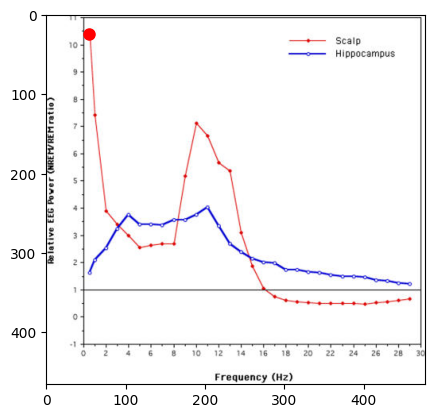

In [19]:
def show_point_on_image(image_path, x, y):
    # Read the image using matplotlib
    image = plt.imread(image_path)

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot the point on the image
    ax.plot(x, y, marker='o', markersize=8, color='red')  # You can customize marker style and color

    # Show the plot
    plt.show()

show_point_on_image(image_path, 54,24)